In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import datasets
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_log_error
from scipy.stats import pearsonr
from sklearn.metrics import r2_score



In [2]:
# Load dataset
df_SOAP = pd.read_csv('SOAP.csv')
df_MAGPIE = pd.read_csv('MAGPIE.csv')
df_Basic = pd.read_csv('Basic_Features.csv')
df_Class = pd.read_csv('Class.csv')
target = df_Basic['tc']

In [3]:
df_SOAP.head()

,0_SOAP,1_SOAP,2_SOAP,3_SOAP
0,0.087405,2.350832,0.716843,2.457795
1,-6.277936,-0.735617,0.489058,2.256497
2,0.113213,2.377825,0.791783,2.481894
3,-6.406671,-0.469702,0.563018,2.287582
4,7.747548,1.573962,-8.671539,0.448773


In [4]:
df_MAGPIE.head()

,0_MAGPIE,1_MAGPIE,2_MAGPIE,3_MAGPIE,4_MAGPIE,5_MAGPIE,6_MAGPIE
0,0.284246,1.745726,2.041545,-3.365978,-0.839857,-3.981347,0.122126
1,4.095951,4.684014,8.332122,-0.700109,1.918350,-1.209732,2.599394
2,0.249922,1.754526,2.019528,-3.379637,-0.822045,-4.051984,0.115422
3,3.802709,4.463046,8.011247,-0.672809,2.283180,-1.274138,2.947561
4,-2.389001,-1.470349,0.211697,-0.269278,-0.293928,0.586055,-0.910411


In [5]:
df_Basic.head()

,formula_sc,formula_similarity,totreldiff,formula_frac,correct_formula_frac,formula_2,orig_formula_cif,tc,sc_class,sc_class_unique_sc,...,orthorhombic,tetragonal,triclinic,trigonal,primitive,base-centered,body-centered,face-centered,weight,IS_SC
0,Ag0.02Ge2Pd1.98Sr1,2,0.008000,1.0,True,Ag0.02Ge2Pd1.98Sr1,Ge2Pd2Sr1,2.64,Other,True,...,0,7,0,0,0,0,1,0,1.0,1
1,Ag0.15Sn0.85Te1,3,0.150000,1.0,True,Ag0.15Sn0.85Te1,Sn1Te1,2.15,Other,True,...,0,0,0,0,0,0,0,1,1.0,1
2,Ag0.1Ge2Pd1.9Sr1,2,0.040000,1.0,True,Ag0.1Ge2Pd1.9Sr1,Ge2Pd2Sr1,2.62,Other,True,...,0,7,0,0,0,0,1,0,1.0,1
3,Ag0.1In0.9Te1,3,0.100000,1.0,True,Ag0.1In0.9Te1,In1Te1,1.20,Other,True,...,0,0,0,0,0,0,0,1,1.0,1
4,Ag0.2Ba1Si1.8,3,0.133333,4.0,False,Ag0.8Ba4Si7.2,Ba4Si8,3.20,Other,True,...,0,0,0,0,1,0,0,0,1.0,1


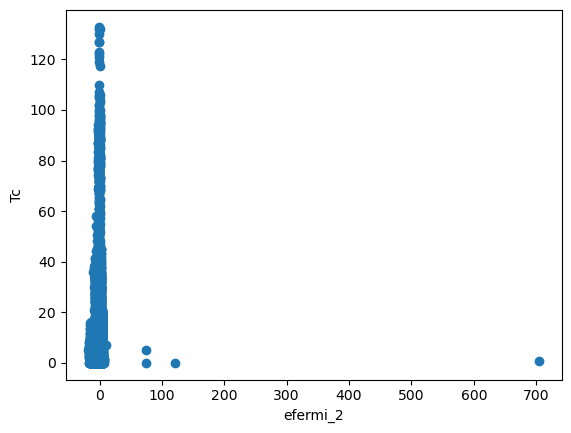

In [4]:
plt.scatter(df_SOAP['3_SOAP'],target)
plt.ylabel('Tc')
plt.xlabel('efermi_2')
plt.show()

In [5]:
pearsonr(target,df_Basic['efermi_2'])

PearsonRResult(statistic=-0.3175734622408654, pvalue=1.9833573861586673e-135)

In [6]:
pearsonr(target,df_Basic['band_gap_2'])

PearsonRResult(statistic=-0.05266602334948726, pvalue=6.241482232947488e-05)

In [7]:
pearsonr(target,df_Basic['latc_2'])

PearsonRResult(statistic=0.3323068318605741, pvalue=7.268902743652396e-149)

In [8]:
pearsonr(target,df_Basic['formation_energy_per_atom_2'])

PearsonRResult(statistic=-0.3354127689356193, pvalue=8.560436747591229e-152)

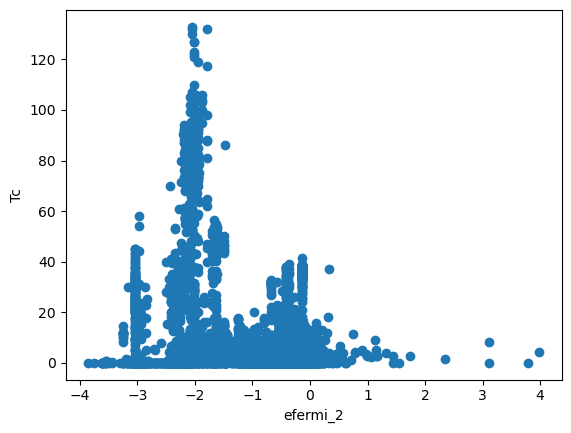

In [9]:
plt.scatter(df_Basic['formation_energy_per_atom_2'],target)
plt.ylabel('Tc')
plt.xlabel('efermi_2')
plt.show()

In [10]:
#Function that allows us to run the ML several times. Average the output. 
def runKRR_NTimes(N,features,targets,gam,alp):
    MSLE = []
    
    for i in range(N):
        #Split the data and targets into test train
        X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.33)
        #Apply KRR ML
        KRR = KernelRidge(kernel="rbf", gamma=gam,alpha=alp)
        KRR.fit(X_train, y_train)

        #Predict based on X_test
        KRR_pred=KRR.predict(X_test)

        #If our prediction for Tc is negative, we should set the Tc to 0.
        #Make a copy before we start changing elements in the dataframe to avoind warnings. 
        KRR_pred_Pos = KRR_pred.copy()
        #Set negative values to positive
        for i in range(len(KRR_pred_Pos)):
            if KRR_pred_Pos[i]<0:
                KRR_pred_Pos[i]=0

        #Find the mean square log error (MSLE)
        MSLE.append(mean_squared_log_error(y_test, KRR_pred_Pos))
    return MSLE


In [11]:
df_M_S = df_SOAP.join(df_MAGPIE)

In [12]:
# res = runKRR_NTimes(10,df_M_S,target,.1,.12)
# sum(res)/len(res)

In [13]:
#Function that allows us to run the ML several times. This function scales the Tc
#Average the output of this function after using. 
def runKRR_NTimes_log(N,features,targets,gam,alp):
    MSLE = []
    targets_L = np.arcsinh(targets)
    for i in range(N):
        #Split the data and targets into test train
        X_train, X_test, y_train, y_test = train_test_split(features, targets_L, test_size=0.2)
        #Apply KRR ML
        KRR = KernelRidge(kernel="laplacian", gamma=gam,alpha=alp)

        KRR.fit(X_train, y_train)

        #Predict based on X_test
        KRR_pred=KRR.predict(X_test)

        #If our prediction for Tc is negative, we should set the Tc to 0.
        #Make a copy before we start changing elements in the dataframe to avoind warnings. 
        KRR_pred_Pos = KRR_pred.copy()
        #Set negative values to positive
        for i in range(len(KRR_pred_Pos)):
            if KRR_pred_Pos[i]<0:
                KRR_pred_Pos[i]=0

        #Find the mean square log error (MSLE)
        MSLE.append(mean_squared_log_error(np.sinh(y_test), np.sinh(KRR_pred_Pos)))
    return MSLE


In [49]:
res = runKRR_NTimes_log(50,df_M_S,target,.1,.12)
res =np.array(res)
print(np.average(res))
print(np.std(res))
#sum(res)/len(res)

0.5877793377011504
0.042783782145864445


In [15]:
#For MAGPIE 7 PCA features and SOAP 4 PCA features .1, .12 hyperparams: MSLE_avg=0.67

In [44]:
#Function that allows us to run the ML several times. This function scales the Tc
#Average the output of this function after using. 
def runKRR_R2(N,features,targets,gam,alp):
    R2 = []
    targets_L = np.arcsinh(targets)
    for i in range(N):
        #Split the data and targets into test train
        X_train, X_test, y_train, y_test = train_test_split(features, targets_L, test_size=0.2)
        #Apply KRR ML
        KRR = KernelRidge(kernel="laplacian", gamma=gam,alpha=alp)

        KRR.fit(X_train, y_train)

        #Predict based on X_test
        KRR_pred=KRR.predict(X_test)

        #If our prediction for Tc is negative, we should set the Tc to 0.
        #Make a copy before we start changing elements in the dataframe to avoind warnings. 
        KRR_pred_Pos = KRR_pred.copy()
        #Set negative values to positive
        for i in range(len(KRR_pred_Pos)):
            if KRR_pred_Pos[i]<0:
                KRR_pred_Pos[i]=0

        #Find the mean square log error (MSLE)
        R2.append(r2_score(np.sinh(y_test), np.sinh(KRR_pred_Pos)))
    return R2


In [50]:
res = runKRR_R2(50,df_M_S,target,.1,.12)
res =np.array(res)
print(np.average(res))
print(np.std(res))

0.6685640988855789
0.04594468416872976


In [20]:
#Function that allows us to run the ML Once. This function scales the Tc
#Average the output of this function after using. 
def runKRR(features,targets,gam,alp):
    targets_L = np.arcsinh(targets)

    #Split the data and targets into test train
    X_train, X_test, y_train, y_test = train_test_split(features, targets_L, test_size=0.2)
    #Apply KRR ML
    KRR = KernelRidge(kernel="laplacian", gamma=gam,alpha=alp)

    KRR.fit(X_train, y_train)

    #Predict based on X_test
    KRR_pred=KRR.predict(X_test)

    #If our prediction for Tc is negative, we should set the Tc to 0.
    #Make a copy before we start changing elements in the dataframe to avoind warnings. 
    KRR_pred_Pos = KRR_pred.copy()
    #Set negative values to positive
    for i in range(len(KRR_pred_Pos)):
        if KRR_pred_Pos[i]<0:
            KRR_pred_Pos[i]=0

    return np.sinh(KRR_pred_Pos),np.sinh(y_test)


In [21]:
predicted,y_test = runKRR(df_M_S,target,.1,.12)

[]

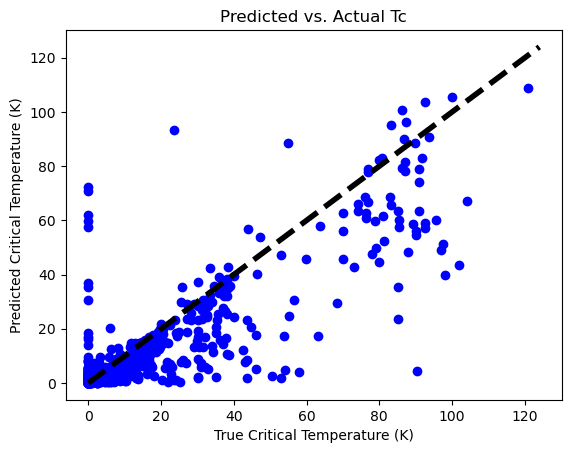

In [39]:
xref=np.arange(0,125)
plt.scatter(y_test,predicted,c='b')
plt.plot(xref,xref,'k',linestyle='dashed',linewidth=4)
# plt.xlim(0,160)
# plt.ylim(0,160)
plt.xlabel('True Critical Temperature (K)')
plt.ylabel('Predicted Critical Temperature (K)')
plt.title('Predicted vs. Actual Tc')
plt.savefig('MS_SC_Full.png',dpi=600)
plt.plot()

[]

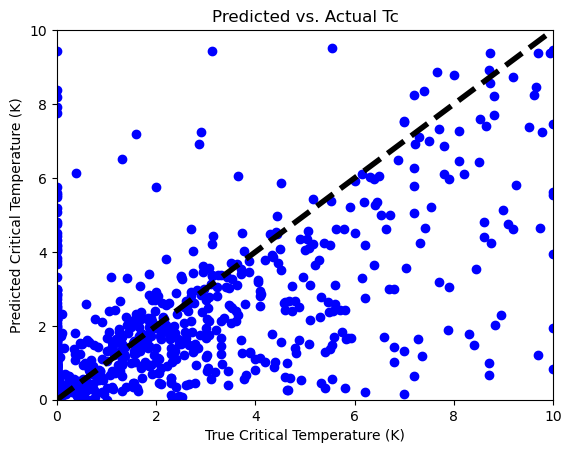

In [43]:
xref=np.arange(0,20)
plt.scatter(y_test,predicted,c='b')
plt.plot(xref,xref,'k',linestyle='dashed',linewidth=4)
plt.xlim(0,10)
plt.ylim(0,10)
plt.xlabel('True Critical Temperature (K)')
plt.ylabel('Predicted Critical Temperature (K)')
plt.title('Predicted vs. Actual Tc')
plt.savefig('MS_SC_Zoomed.png',dpi=600)
plt.plot()

In [103]:
df_M_S_X = df_M_S.join(df_Basic['efermi_2'])
res = runKRR_R2(10,df_M_S_X,target,.1,.12)
sum(res)/len(res)

0.6801145375673452

In [106]:
res = runKRR_NTimes_log(10,df_M_S_X,target,.1,.12)
sum(res)/len(res)

0.5722939618875479

In [62]:
df_M_S_X = df_M_S.join(df_Basic['formation_energy_per_atom_2'])
res = runKRR_R2(50,df_M_S_X,target,.1,.12)
sum(res)/len(res)

0.673111506204944

In [64]:
df_M_S_X = df_M_S.join(df_Basic['latc_2'])
res = runKRR_R2(50,df_M_S_X,target,.1,.12)
sum(res)/len(res)

0.6775909584080827

In [51]:
# df_M_S_X = df_Basic['efermi_2'].join(df_Basic['latc_2'])
# df_M_S_X = df_M_S_X.join(df_Basic['formation_energy_per_atom_2'])
df_NoMS = pd.concat([df_Basic['efermi_2'],df_Basic['latc_2'],df_Basic['lata_2'],df_Basic['formation_energy_per_atom_2']],axis=1)


res = runKRR_R2(50,df_NoMS,target,2,.12)
res =np.array(res)
print(np.average(res))
print(np.std(res))

0.631842840769673
0.03504992240952687


In [52]:
res = runKRR_NTimes_log(50,df_NoMS,target,2,.12)
res =np.array(res)
print(np.average(res))
print(np.std(res))

0.7838395449460434
0.056119478143322084


In [70]:
predicted,y_test = runKRR(df_NoMS,target,2,.12)

[]

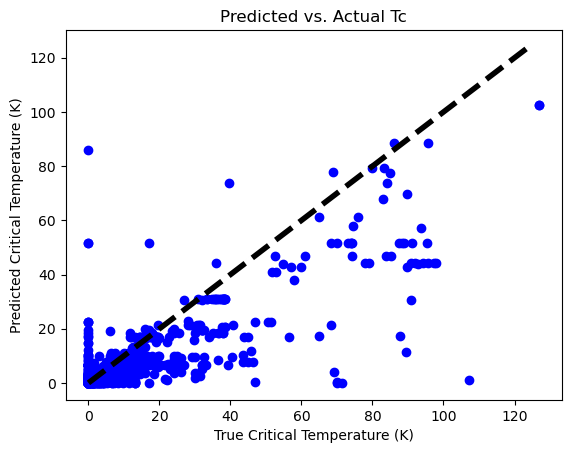

In [71]:
xref=np.arange(0,125)
plt.scatter(y_test,predicted,c='b')
plt.plot(xref,xref,'k',linestyle='dashed',linewidth=4)
# plt.xlim(0,160)
# plt.ylim(0,160)
plt.xlabel('True Critical Temperature (K)')
plt.ylabel('Predicted Critical Temperature (K)')
plt.title('Predicted vs. Actual Tc')
plt.savefig('NoMS_SC_Full.png',dpi=600)
plt.plot()

In [57]:
df__Class_NoMS = pd.concat([df_NoMS,df_Class],axis=1)
#df__Class_NoMS.head()

In [65]:
res = runKRR_NTimes_log(50,df__Class_NoMS,target,1,.12)
res =np.array(res)
print(np.average(res))
print(np.std(res))

0.7655561932180258
0.04116153792677735


In [66]:
res = runKRR_R2(50,df__Class_NoMS,target,1,.12)
res =np.array(res)
print(np.average(res))
print(np.std(res))

0.6373983040646545
0.038405267236429355


In [67]:
predicted,y_test = runKRR(df__Class_NoMS,target,1,.12)

[]

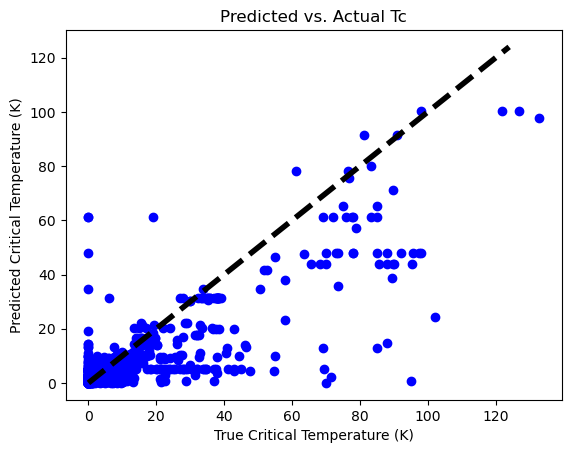

In [69]:
xref=np.arange(0,125)
plt.scatter(y_test,predicted,c='b')
plt.plot(xref,xref,'k',linestyle='dashed',linewidth=4)
# plt.xlim(0,160)
# plt.ylim(0,160)
plt.xlabel('True Critical Temperature (K)')
plt.ylabel('Predicted Critical Temperature (K)')
plt.title('Predicted vs. Actual Tc')
plt.savefig('Class_NoMS_SC_Full.png',dpi=600)
plt.plot()